In [254]:
import matplotlib.pyplot as plt # used for plotting
import numpy as np # used for most numerical operations
import math # used for floor function
%matplotlib inline

## 5.2 - Reverse Fourier Transform

Use the Fourier series for a square wave to generate a wave of a given frequency.

For a square wave, $f(x)=\sum_{k=1}^{\infty}\frac{2}{k\pi}\left(1-(-1)^k\right)\sin{\left(\frac{2k\pi x}{L}\right)}$

In [255]:
fs=10000. # sampling frequency
nsample=1000 # number of samples

def sqare_wave(f: float, amp: float, sample_nums: np.ndarray, fourier_terms: int = 1000):
    """ Returns a sqare wave with frequency f and amplitude amp, sampled at 
    positions in array sample_nums divided by the sampling frequency.
    fourier_terms is the number of terms in the Fourier series to use
    """
    L = f/fs
    y=0
    for k in range(1,fourier_terms+1):
        y += 2*(1-(-1)**k)/(k*np.pi)*np.sin(2*np.pi*(k)*sample_nums/fs/L)
    
    return amp*y

Generate example signal and plot

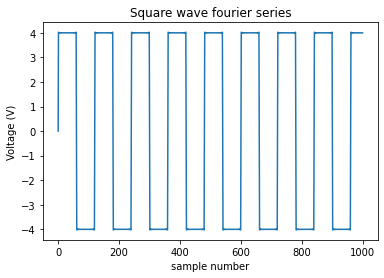

In [256]:
sample_nums = np.arange(nsample) # sample numbers
# plot signal
signal = sqare_wave(120,4, sample_nums)
plt.plot(signal)
plt.xlabel("sample number")
plt.ylabel("Voltage (V)")
plt.title("Square wave fourier series")
plt.savefig("square_wave_fourier_series.png")
plt.show()

Get Fourier transform of signal and plot

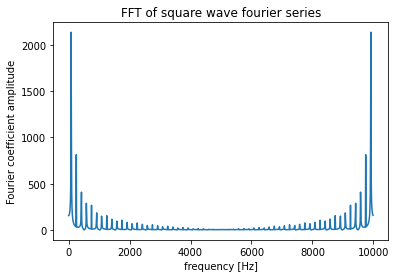

In [257]:
# perform the FFT. Outputs list of complex numbers
fourier=np.fft.fft(signal)
# frequencies for the coefficient from the FFT
ffs=fs/nsample*sample_nums
# plot FFT
plt.plot(ffs,abs(fourier))
plt.xlabel("frequency [Hz]")
plt.ylabel("Fourier coefficient amplitude")
plt.title("FFT of square wave fourier series")
plt.savefig("FFT_square_wave_fourier_series.png")
plt.show()

We also plot the phase. To make the plot look better, we only plot the phases where the amplitude of the FFT is large (since the phases are only meaningful where the FFT amplitude is significant). Elsewhere in the plot we set the phase to 0. Note that the phase is antisymmetric about the Nyquist frequency $f_N = f_s/2$

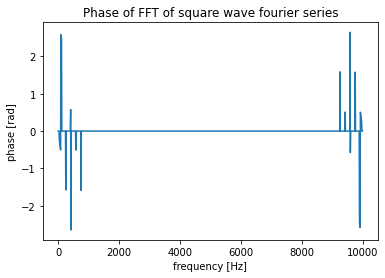

In [258]:
# we also want to plot the phase of the FFT
# we only plot when the amplitude of the FFT coefficient is large
# to avoid plotting noise
min_amplitude = 200
angles = [np.angle(fourier[i]) if abs(fourier[i])>min_amplitude else 0 for i in range(len(fourier)) ]
plt.plot(ffs, angles)
plt.xlabel("frequency [Hz]")
plt.ylabel("phase [rad]")
plt.title("Phase of FFT of square wave fourier series")
plt.savefig("phase_FFT_square_wave_fourier_series.png")
plt.show()

Perform inverse FT to get the original signal back

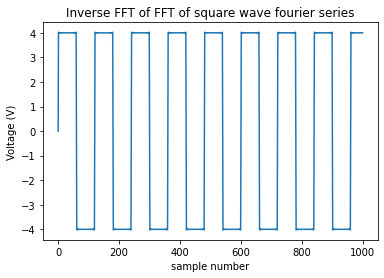

In [259]:
# inverse FFT (use real part because numerical errors will introduce non-zero (but small) imaginary part)
reverse=np.real(np.fft.ifft(fourier))
# plot inverse FFT
plt.plot(reverse)
plt.xlabel("sample number")
plt.ylabel("Voltage (V)")
plt.title("Inverse FFT of FFT of square wave fourier series")
plt.savefig("inverse_FFT_square_wave_fourier_series.png")
plt.show()

We also plot the inverse of the FFT of the series with the phase set to 0 on all the coefficients (i.e. plotting the FFT of only the magnitude with no imaginary part)

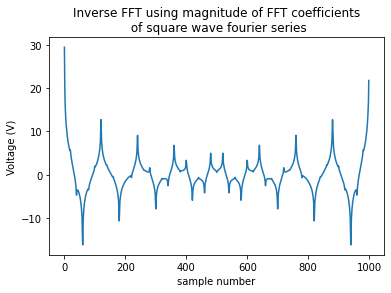

In [260]:
# compute inverse FFT using only magnitude of FFT coefficients (equivalent to setting phase to 0)
reverse_real =np.real(np.fft.ifft(np.abs(fourier)))

# plot inverse FFT
plt.plot(reverse_real)
plt.xlabel("sample number")
plt.ylabel("Voltage (V)")
plt.title("Inverse FFT using magnitude of FFT coefficients\n of square wave fourier series")
plt.savefig("inverse_FFT_magnitude_square_wave_fourier_series.png")
plt.show()

We now zero all frequencies above the Nyquist frequency and do an inverse FFT

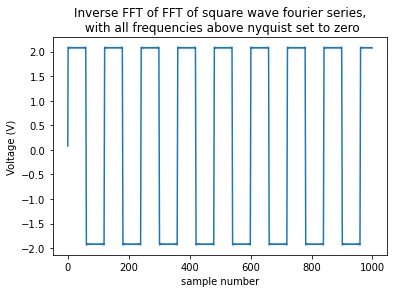

In [261]:
nyquist = fs/2 # nyquist frequency
num_frequencies = nyquist/fs * len(ffs) # number of frequencies in the FFT below the nyquist frequency

# initialise corrected_fourier to be all zeros, then replace all the values below the nyquist frequency with the original values
# we have to specify dtype=complex otherwise it will cast the complex numbers to floats in the next line
corrected_fourier = np.zeros(len(fourier), dtype=complex) 
corrected_fourier[:int(num_frequencies)] = fourier[:int(num_frequencies)]

# do the inverse DFT
corrected_reverse = np.real(np.fft.ifft(corrected_fourier))

# plot the signal
plt.plot(corrected_reverse)
plt.xlabel("sample number")
plt.ylabel("Voltage (V)")
plt.title("Inverse FFT of FFT of square wave fourier series,\n with all frequencies above nyquist set to zero")
plt.savefig("inverse_FFT_nyquist_square_wave_fourier_series.png")
plt.show()


## 5.3 Leakage

We generate a pure sine wave with a sample number slightly different from the frequency (we choose 350 samples and a frequency of 300Hz), and then use various methods to reduce problems caused by leakage

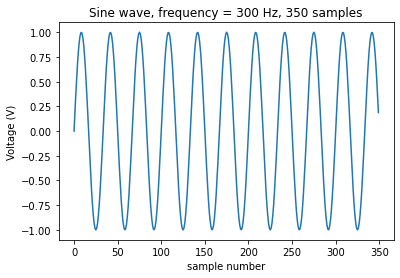

In [262]:
# generate a sine wave and plot
nsample = 350
sample_nums = np.arange(nsample)
freq = 300
signal = np.sin(2*np.pi*sample_nums*freq/fs)
plt.plot(signal)
plt.xlabel("sample number")
plt.ylabel("Voltage (V)")
plt.title("Sine wave, frequency = 300 Hz, 350 samples")
plt.savefig("sine_wave_300Hz_350samples.png")
plt.show()

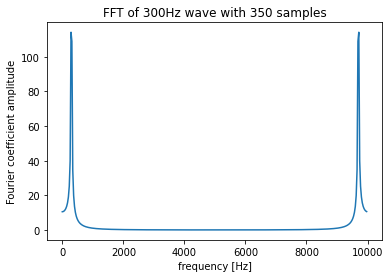

In [263]:
# perform fourier series of sine wave
fourier = np.fft.fft(signal)
ffs=fs/nsample*sample_nums
# plot FFT
plt.plot(ffs,abs(fourier))
plt.xlabel("frequency [Hz]")
plt.ylabel("Fourier coefficient amplitude")
plt.title("FFT of 300Hz wave with 350 samples")
plt.savefig("FFT_sine_wave_300Hz_350samples.png")
plt.show()

We now generate a reflected signal, and perform a FFT to check that leakage is reduced

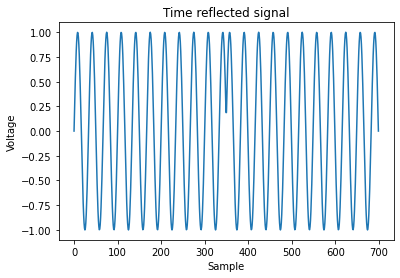

In [264]:
# convert signal to a list to allow us to use the append method, which is not available for numpy arrays
time_reflected = list(signal)
# reflect the signal
for i in range(len(signal)):
    time_reflected.append(signal[len(signal)-i-1])
plt.plot(time_reflected)
plt.xlabel("Sample")
plt.ylabel("Voltage")
plt.title("Time reflected signal")
plt.savefig("time_reflected_signal.png")
plt.show()

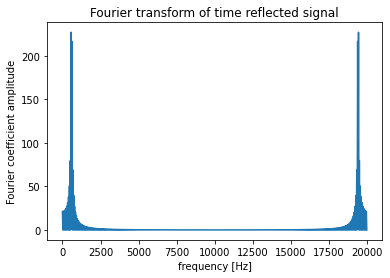

In [265]:
time_reflected_fourier = np.fft.fft(time_reflected)
sample_nums = np.arange(nsample*2) # sample numbers
ffs=fs/nsample*sample_nums

plt.plot(ffs,abs(time_reflected_fourier))
plt.xlabel("frequency [Hz]")
plt.ylabel("Fourier coefficient amplitude")
plt.title("Fourier transform of time reflected signal")
plt.savefig("ft_of_time_reflected_signal.png")
plt.show()


Use a Hamming window to reduce leakage

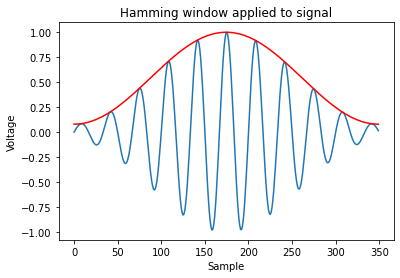

In [266]:
hamming_window = np.hamming(nsample)
corrected_signal = signal*hamming_window
plt.plot(corrected_signal)
plt.plot(hamming_window, color="red")
plt.xlabel("Sample")
plt.ylabel("Voltage")
plt.title("Hamming window applied to signal")
plt.savefig("hamming_window.png")
plt.show()

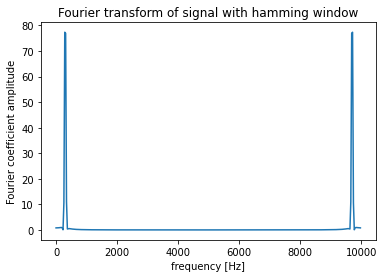

In [267]:
hamming_fourier = np.fft.fft(corrected_signal)
sample_nums = np.arange(nsample) # sample numbers
ffs=fs/nsample*sample_nums
plt.plot(ffs,abs(hamming_fourier))
plt.xlabel("frequency [Hz]")
plt.ylabel("Fourier coefficient amplitude")
plt.title("Fourier transform of signal with hamming window")
plt.savefig("ft_of_hamming_window.png")
plt.show()

## 5.4.1 - Interpolation

We generate a sinusoidal signal of frequency 120Hz, but only sampled 20 times, and then use interpolation to reconstruct a signal and compare it to the original

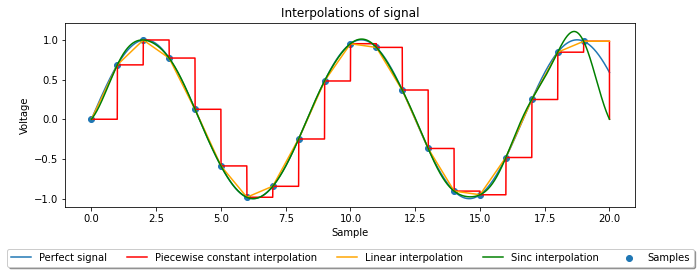

In [280]:
fs = 1000 # sampling frequency
nsample = 20
freq = 120
xvals = np.linspace(0, nsample, 10000) # places that we "sample" our interpolated signals for plotting

# to reducce the error in the sinc interpolation, use the following 
# to generate a "fake" point outside of the plotting range to interpolate to
# nsample = 21 # generate the fake point
# xvals = np.linspace(0, nsample-1, 10000) # only plot up to nsample-1

sample_nums = np.arange(nsample) # sample numbers
signal = np.sin(2*np.pi*sample_nums*freq/fs)
perfect_signal = np.sin(2*np.pi*xvals*freq/fs) # signal sampled at 10000 points for comparison



# picewise constant interpolation
pci = []
for x in xvals:
    if x < 0 or x >= nsample:
        pci.append(0)
    else:
        pci.append(signal[math.floor(x)])

# liner interpolation
li = np.interp(xvals, sample_nums, signal)

#sinc interpolation
def whittaker_shannon(x):
    N=nsample
    rep = 0

    for i in range(N):
        rep+=signal[i] * np.sinc((x-i*1/fs)/(1/fs))
    return rep

sinc = []
for x in xvals:
    sinc.append(whittaker_shannon(x/fs))

# plotting
fig = plt.figure()
fig.set_figwidth(10)
ax = plt.subplot(111)
ax.scatter(sample_nums, signal, label = "Samples")
ax.plot(xvals, perfect_signal, label = "Perfect signal")
ax.plot(xvals, pci, color = "red", label="Piecewise constant interpolation")
ax.plot(xvals, li, color = "orange", label="Linear interpolation")
ax.plot(xvals, sinc, color = "green", label="Sinc interpolation")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
plt.xlabel("Sample")
plt.ylabel("Voltage")
plt.title("Interpolations of signal")
plt.tight_layout() # required so savefig doesn't cut off the legend
plt.savefig("interpolations.png")

plt.show()

In [ ]:
# calculate the error between the perfect signal and the interpolated signals
def rms(f1, f2):
    return np.sqrt(np.mean((f1-f2)**2))

print("RMS of piecewise constant interpolation: ", rms(perfect_signal, pci))
print("RMS of linear interpolation: ", rms(perfect_signal, li))
print("RMS of sinc interpolation: ", rms(perfect_signal, sinc))

RMS of piecewise constant interpolation:  0.29904989499933887
RMS of linear interpolation:  0.05652357091644098
RMS of sinc interpolation:  0.08929843190358666


## 5.4.2 - Digital-to-Analogue conversion

We perform a FFT of the picewise constant interpolated signal, remove all freqencies above the nyquist and then perform an inverse FFT and plot

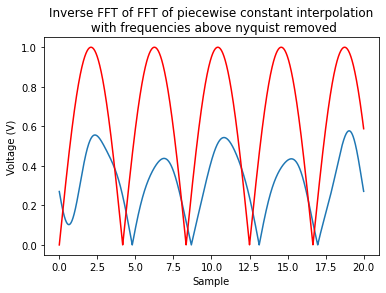

In [ ]:
# fft of picewise constant interpolation
pci_fourier = np.fft.fft(pci)
ffs = fs/nsample*xvals

# remove all frequencies above the nyquist frequency, then inverse transform
adjusted_pci_fourier = np.zeros(len(pci_fourier), dtype=complex)
adjusted_pci_fourier[:int(nsample/2)] = pci_fourier[:int(nsample/2)]
reverse_pci_fourier = np.real(np.fft.ifft(adjusted_pci_fourier))

plt.plot(xvals,abs(reverse_pci_fourier))
plt.plot(xvals,abs(perfect_signal), color="red")
plt.xlabel("Sample")
plt.ylabel("Voltage (V)")
plt.title("Inverse FFT of FFT of piecewise constant interpolation\n with frequencies above nyquist removed")
plt.savefig("inverse_fft_of_pci.png")
plt.show()
